# Group GeoVar

### Members: Raul Fuentes and Mateo Vanoy Marin

## Challenge 1

Improve inaccurate geo-positioning of sharing vehicles due to zones of the city to critical zones of the city  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime, date
import folium
from arcgis.gis import GIS
from arcgis.geocoding import reverse_geocode

Load data sets

In [3]:
dfGlon=pd.read_csv('4780-LMH.csv')
dfGali=pd.read_csv('4846-LMH.csv')

In [4]:
{dfGlon.columns.get_loc(c): c for idx, c in enumerate(dfGlon.columns)}

{0: 'vehicle_identifier',
 1: ' vehicle_identification_number',
 2: ' gps_lat',
 3: ' gps_lng',
 4: ' battery_charge',
 5: ' vehicle_status',
 6: ' created_on'}

Change columns' name to simplify latitude and longitude name

In [5]:
dfGlon=dfGlon.rename(columns={" gps_lng": "lng", " gps_lat": "lat"})

dfGali=dfGali.rename(columns={" gps_lng": "lng", " gps_lat": "lat"})

Plot coordinates for each data set

In [6]:
points = []
      
for index, row in dfGlon.iterrows():
    points.append(tuple([row['lat'], row['lng']]))

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)  

points2 = []
for index, row in dfGali.iterrows():
    points2.append(tuple([row['lat'], row['lng']]))

#Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)
 
#add a markers
for each in points:  
    folium.Marker(each,icon=folium.Icon(color='red'),popup=str(each)).add_to(my_map)
i=0
for each in points2:  
    folium.Marker(each,icon=folium.Icon(color='green'),popup=str(each)+str(dfGali[' created_on'][i])).add_to(my_map) 
    i+=1
    
#fadd lines
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(my_map)
folium.PolyLine(points2, color="green", weight=2.5, opacity=1).add_to(my_map)

# GLO -> RED
# GAL -> GREEN
my_map

On this map, it is possible to see cluster of points that may be due to the vehicle stoping at a traffic light. This creates a lot of noise on the route. The velocities of the points will be estimated, so we can filter these stationary points.

Extract velocities for each coordinates and save this information in the dataframe

In [7]:
# Work on copies of the data frames
dfGali_cop = dfGali.copy()
dfGlon_cop = dfGlon.copy()

In [8]:
#GALLILEO
diflat1=[0]
diflng1=[0]
vec1=[]
Lg=dfGali_cop.columns.get_loc('lng')
L=dfGali_cop.columns.get_loc('lat')
D=dfGali_cop.columns.get_loc(' created_on')
i=0
while i<len(dfGali_cop)-1:
    start = datetime.strptime(dfGali_cop.iloc[i,D][:-3], '%Y-%m-%d %H:%M:%S.%f').time()
    end = datetime.strptime(dfGali_cop.iloc[i+1,D][:-3], '%Y-%m-%d %H:%M:%S.%f').time()
    #Latitude vel
    diflat1.append(111.32*1000*(dfGali_cop.iloc[i+1,L]-dfGali_cop.iloc[i,L])/
                   (datetime.combine(date.today(), end) - datetime.combine(date.today(), start)).total_seconds())
    #Longitude vel
    diflng1.append(40075000*np.cos(np.deg2rad(42.39))/360*(dfGali_cop.iloc[i+1,Lg]-dfGali_cop.iloc[i,Lg])/
                   (datetime.combine(date.today(), end) - datetime.combine(date.today(), start)).total_seconds())
    #Join both velocities
    vec1.append(3.6*(diflat1[i]**2+diflng1[i]**2)**0.5)
    i+=1    
vec1.append(3.6*(diflat1[-1]**2+diflng1[-1]**2)**0.5)
#GLONNAS
diflat2=[0]
diflng2=[0]
vec2=[]
Lg=dfGlon.columns.get_loc('lng')
L=dfGlon_cop.columns.get_loc('lat')
D=dfGlon_cop.columns.get_loc(' created_on')

i=0
while i<len(dfGlon_cop)-1:
    start = datetime.strptime(dfGlon_cop.iloc[i,D][:-3], '%Y-%m-%d %H:%M:%S.%f').time()
    end = datetime.strptime(dfGlon_cop.iloc[i+1,D][:-3], '%Y-%m-%d %H:%M:%S.%f').time()
    #Latitude
    diflat2.append(111.32*1000*(dfGlon_cop.iloc[i+1,L]-dfGlon_cop.iloc[i,L])/
                   (datetime.combine(date.today(), end) - datetime.combine(date.today(), start)).total_seconds())
    #Longitude
    diflng2.append(40075000*np.cos(np.deg2rad(42.39))/360*(dfGlon_cop.iloc[i+1,Lg]-dfGlon_cop.iloc[i,Lg])/
                   (datetime.combine(date.today(), end) - datetime.combine(date.today(), start)).total_seconds()) 
    #Join both velocities
    vec2.append(3.6*(diflat2[i]**2+diflng2[i]**2)**0.5)
    i+=1
vec2.append(3.6*(diflat2[-1]**2+diflng2[-1]**2)**0.5)


In [9]:
#Insert new columns with the velocity information
#Galileo
dfGali_cop.insert(7, "Vlat", diflat1, True)
dfGali_cop.insert(7, "Vel", vec1, True)
dfGali_cop.insert(7, "Vlng", diflng1, True)
#Glonnas
dfGlon_cop.insert(7, "Vlat", diflat2, True)
dfGlon_cop.insert(7, "Vel", vec2, True)
dfGlon_cop.insert(7, "Vlng", diflng2, True)

<function matplotlib.pyplot.show(close=None, block=None)>

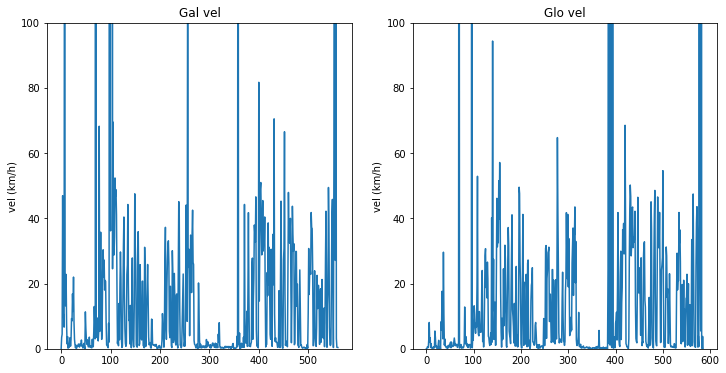

In [10]:
# Plot total velocity each coordinate
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(vec1)
ax.set_ylim([0, 100])
ax.set_title('Gal vel')
ax.set_ylabel('vel (km/h)')
ax2.plot(vec2)
ax2.set_ylim([0, 100])
ax2.set_title('Glo vel')
ax2.set_ylabel('vel (km/h)')
plt.show

Check for velocity to filter stationary coordinates

In [11]:
def check_vel(df):
    df6=pd.DataFrame()
    i=0
    ind=[]
    times=0
    while i<len(df):
        if df['Vel'][i] <10: # check of vehicles under 10 km/h
            # The noise may create small fluctuations in velocity
            times+=1
        else:
            if times>1: #Average velocity of stationary coordinates
                ave_lat = sum(df['lat'][i-times+p] for p in range(times))/times
                ave_lon = sum(df['lng'][i-times+p] for p in range(times))/times
                for p in range(times):
                    if p==0: #Change first stationary point with average
                        df['lng'][i-times+p]=ave_lon
                        df['lat'][i-times+p]=ave_lat
                    else: #save index of rest stationary points
                        ind.append(i-times+p)
            times=0
            
        if df['Vel'][i]>65: # check vehicles above 65 km/h
            #  Vel too high for city limit, possible error
            #  Take average between previous and future pointu
            #  Note: future use projection of previous point for current
            df['lng'][i]=(df['lng'][i-1]+df['lng'][i+1])/2
            df['lat'][i]=(df['lat'][i-1]+df['lat'][i+1])/2
            
        i+=1
    
    i=0
    while i<len(df): 
        if i not in ind: #exclude stationary points from saved index
            df6=df6.append(df.iloc[[i]])
        i+=1
    return df6
            

In [12]:
# Check for vehicles velocity and save in new data frame
dfGali_V_corr   = check_vel(dfGali_cop)
dfGlon_cop_corr = check_vel(dfGlon_cop)

<ipython-input-11-4022e56c66d7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lng'][i-times+p]=ave_lon
<ipython-input-11-4022e56c66d7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'][i-times+p]=ave_lat
<ipython-input-11-4022e56c66d7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lng'][i]=(df['lng'][i-1]+df['lng'][i+1])/2
<ipython-input-11-4022e56c66d7>:27: SettingWithCopyWarning: 
A value is trying to be set

Compare filterd gallleo coordinates with original data set

In [13]:
points = []    
for index, row in dfGali_V_corr.iterrows():
    points.append(tuple([row['lat'], row['lng']]))

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)    

points2 = []
for index, row in dfGali.iterrows():
    points2.append(tuple([row['lat'], row['lng']]))

#Load map centred on average coordinates
my_map2 = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

for each in points:  
    folium.Marker(each,popup=str(each)).add_to(my_map2)
    
# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)
 
#add a markers
i=0
for each in points:  
    folium.Marker(each,icon=folium.Icon(color='blue'),popup=str(each)+str(dfGali_V_corr.iloc[i][' created_on'])).add_to(my_map2) 
    i+=1
i=0
for each in points2:  
    #folium.Marker(each,icon=folium.Icon(color='green'),popup=str(each)+str(dfGali[' created_on'][i])).add_to(my_map2) 
    i+=1

#faded lines
folium.PolyLine(points, color="blue", weight=1.5, opacity=1).add_to(my_map2)
folium.PolyLine(points2, color="green", weight=1.5, opacity=1).add_to(my_map2)
#GAL
#ORG -> Green
#FILT -> Blue
my_map2

To further correct the path, ArcGis API is implemented. reverse_geocode(lon,lat) returns a coordinate closest to the street as well as providing valuable location information like street name and number. Since these coordinates are the closest to the street, they are assumed to be the correct position. 

The function geo_val(df) provides some features that allows to smooth our the path as best as possible. It takes 3 points (past, current and future) and compare the street name ('addres') of all points to check if there is an unusual path change and correct it. Also it's able to work when the vehicle is driving thorugh an undercover area like a tunnel. For this feature, it is assume that we have the street name where a tunnel is present and streets in proximity to the tunnel street.

In [14]:
def geo_val(df):
    global puntos
    global tunel
    results = reverse_geocode([df.iloc[0]['lng'],df.iloc[0]['lat']]) #Get first coordinate and address
    # Remove street number from Address
    a = str(results['address']['Address'])
    b = str(results['address']['AddNum'])
    t = a.strip(b)
    address_prev = t.strip(t[-1]) if t[-1]==' ' else t
    lng_prev=results['location']['x']
    lat_prev=results['location']['y']
    
    
    results = reverse_geocode([df.iloc[1]['lng'],df.iloc[1]['lat']]) #Get second coordinate and address
    # Remove street number from Address
    a = str(results['address']['Address'])
    b = str(results['address']['AddNum'])
    t = a.strip(b)
    address = t.strip(t[-1]) if t[-1]==' ' else t
    lng=results['location']['x']
    lat=results['location']['y']

    i=1
    times=0
    tun=False
    while i<len(df)-2:
         #Get i+1 coordinate and address
        results = reverse_geocode([df.iloc[i+1]['lng'],df.iloc[i+1]['lat']])
        a = str(results['address']['Address'])
        b = str(results['address']['AddNum'])
        t = a.strip(b)
        if a!='':
            address_post = t.strip(t[-1]) if t[-1]==' ' else t
        else:
            address_post= ''
        lng_post=results['location']['x']
        lat_post=results['location']['y']
        
        #Check if address is in tunels address
        if address in tunel:
            tun = True
            tunCalle = address  
            
        if address_prev==address: #current address equal to past, then correct address
            df.iloc[i,df.columns.get_loc('lng')]=lng
            df.iloc[i,df.columns.get_loc('lat')]=lat
            
        else: # prev address not equal to current
            if address_prev==address_post:# Check if prev and future address the same, then current should be the same
                # calculate average with with past and future
                df.iloc[i,df.columns.get_loc('lng')]=(df.iloc[i-1,df.columns.get_loc('lng')]+df.iloc[i+1,df.columns.get_loc('lng')])/2
                df.iloc[i,df.columns.get_loc('lat')]=(df.iloc[i-1,df.columns.get_loc('lat')]+df.iloc[i+1,df.columns.get_loc('lat')])/2
                address=address_prev
                #Better aproximation should be implemented with velocity if time intervel it's diferent.
            else: # If post and current different to prev address, then it's new address
                if tun == True and address in tunel[tunCalle]: #tunnel street, but close to other close street, not more in tunnel street 
                    df.iloc[i,df.columns.get_loc('lng')]=lng
                    df.iloc[i,df.columns.get_loc('lat')]=lat
                    tun = False
                elif tun == True and address not in tunel[tunCalle]: #If new address not in posible address of tunel, it's in tunnel
                    dist = lambda x, y: (x[0]-y[0])**2 + (x[1]-y[1])**2
                    closePoint = min(puntos[tunCalle], key=lambda co: dist(co, (lat,lng)))
                    df.iloc[i,df.columns.get_loc('lng')]=closePoint[1]
                    df.iloc[i,df.columns.get_loc('lat')]=closePoint[0]
                else: #lejos de tunel
                    df.iloc[i,df.columns.get_loc('lng')]=lng
                    df.iloc[i,df.columns.get_loc('lat')]=lat
                    tun = False
        
        #Update previous and current address with current and post
        if tun == True and address not in tunel[tunCalle]:
            address_prev=tunCalle
        else:
            address_prev=address
        lng_prev=lng
        lat_prev=lat
        
        #Update address and coord with post 
        
        address=address_post
        lng=lng_post
        lat=lat_post


        i+=1

Further correct our path by implementing ArcGIS API and in undercover areas

In [15]:
gis = GIS()
dfGali_Final=dfGali_V_corr.copy()
dfGlon_Final=dfGlon_cop_corr.copy()
# Additonal information assummed to be known about undercover areas
puntos = {'Carrer de Constança':[(41.389485901070856, 2.134582698946384),(41.38977082936831, 2.1343254841460224),(41.39012423399318, 2.1339486333032363),(41.39045996660739, 2.1336235994513326)]}
tunel = {'Carrer de Constança':['Carrer de Déu i Mata','Carrer del Taquígraf Garriga', 'Travessera de les Corts', 'Carrer de Nicaragua']}
geo_val(dfGali_Final)
geo_val(dfGlon_Final)

Compare final corrected routed routes with original coordinates Galileo

In [16]:
points = []
for index, row in dfGali_Final.iterrows():
    points.append(tuple([row['lat'], row['lng']]))

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)    

points2 = []
for index, row in dfGali.iterrows():
    points2.append(tuple([row['lat'], row['lng']]))

#Load map centred on average coordinates
my_map3 = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

#add a markers
i=0
for each in points:  
    folium.Marker(each,icon=folium.Icon(color='blue'),popup=str(each)+str(dfGali_Final.iloc[i][' created_on'])).add_to(my_map3) 
    i+=1
    
i=0
for each in points2:  
    folium.Marker(each,icon=folium.Icon(color='green'),popup=str(each)+str(dfGali.iloc[i][' created_on'])).add_to(my_map3) 
    i+=1

#fadd lines
folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(my_map3)
folium.PolyLine(points2, color="green", weight=1.5, opacity=1).add_to(my_map3)

#GAL
#Original -> Green
#Final -> Blue
my_map3

Compare final corrected routed routes with original coordinates Glonas

In [17]:
points = []
for index, row in dfGlon_Final.iterrows():
    points.append(tuple([row['lat'], row['lng']]))

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)    

points2 = []
for index, row in dfGlon.iterrows():
    points2.append(tuple([row['lat'], row['lng']]))


# Load map centred on average coordinates
my_map4 = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)
 

#add a markers
i=0
for each in points:  
    folium.Marker(each,icon=folium.Icon(color='orange'),popup=str(each)+str(dfGlon_Final.iloc[i][' created_on'])).add_to(my_map4) 
    i+=1
i=0
for each in points2:  
    folium.Marker(each,icon=folium.Icon(color='red'),popup=str(each)+str(dfGlon.iloc[i][' created_on'])).add_to(my_map4) 
    i+=1
#fadd lines
folium.PolyLine(points, color="orange", weight=2.5, opacity=1).add_to(my_map4)
folium.PolyLine(points2, color="red", weight=1.5, opacity=1).add_to(my_map4)

#GLO
#Original -> Red
#Final -> Orange
my_map4

We want to observe if finding the average of the two corrected routes has better results.

In [18]:
#NO FUNCIONA!!!!!!!!!! solo lo escribi
# New data frame holding average of dfGali_Final and dfGlon_Final
dfNew = pd.DataFrame(columns=['lat','lng'])

tmpDict = {'Glon':[], 'Gali':[]}

#Take (lat,lgn) corrdinates 
for index, row in dfGali_Final.iterrows():
    tmpDict['Gali'].append((row['lat'],row['lng']))

for index, row in dfGlon_Final.iterrows():
    tmpDict['Glon'].append((row['lat'],row['lng']))

i = 0
while i<len(dfGali_Final):  
    dist = lambda x, y: (x[0]-y[0])**2 + (x[1]-y[1])**2
    closePoint = min(tmpDict['Glon'], key=lambda co: dist(co, tmpDict['Gali'][i]))
    # Select closest point from other data set to create average
    ave_lat = (tmpDict['Gali'][i][0]+closePoint[0])/2
    ave_lon = (tmpDict['Gali'][i][1]+closePoint[1])/2
    dfNew = dfNew.append({'lat':ave_lat,'lng':ave_lon},ignore_index=True)
    i += 1

# dfNew plot in map and compare

points = []
for index, row in dfGlon_Final.iterrows():
    points.append(tuple([row['lat'], row['lng']]))

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)    

points2 = []
for index, row in dfGali_Final.iterrows():
    points2.append(tuple([row['lat'], row['lng']]))

points3 = []
for index, row in dfNew.iterrows():
    points3.append(tuple([row['lat'], row['lng']]))



# Load map centred on average coordinates
my_map5 = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)
 

#add a markers
i=0
for each in points:  
    folium.Marker(each,icon=folium.Icon(color='orange'),popup=str(each)+str(dfGlon_Final.iloc[i][' created_on'])).add_to(my_map5) 
    i+=1
i=0
for each in points2:  
    folium.Marker(each,icon=folium.Icon(color='blue'),popup=str(each)+str(dfGlon.iloc[i][' created_on'])).add_to(my_map5) 
    i+=1
i=0
for each in points3:  
    folium.Marker(each,icon=folium.Icon(color='black'),popup=str(each)+str(dfGlon.iloc[i][' created_on'])).add_to(my_map5) 
    i+=1
#Conflict Zones
folium.Marker((41.39117799869765, 2.1714383176844594),icon=folium.Icon(color='red')).add_to(my_map5)
folium.Marker((41.402427855338836, 2.2095850408065036),icon=folium.Icon(color='red')).add_to(my_map5)
folium.Marker((41.42629607668137, 2.178534728729327),icon=folium.Icon(color='red')).add_to(my_map5)
folium.Marker((41.39707927096545, 2.1610984060893346),icon=folium.Icon(color='red')).add_to(my_map5)
folium.Marker((41.38991293556385, 2.134182994705349),icon=folium.Icon(color='red')).add_to(my_map5)

#fadd lines
folium.PolyLine(points, color="orange", weight=2.5, opacity=1).add_to(my_map5)
folium.PolyLine(points2, color="blue", weight=1.5, opacity=1).add_to(my_map5)
folium.PolyLine(points3, color="black", weight=1.5, opacity=1).add_to(my_map5)

#Gali Final -> Blue
#Glon Final -> Orange
#New        -> black
my_map5

## Future Plan

Use a data set like this one that provides information about all the intersections in the city of Barcelona. This can be used to create statistical model of the streets and use coordinates position and velocity to estimate the path of the vehicle. The idea is to provide online correction of the received coordinates.

(4573000.0, 4591142.0)

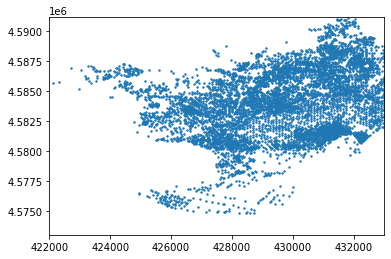

In [19]:
dfNode=pd.read_csv('BCN_GrafVial_Nodes_ETRS89_CSV.csv')
dfNode['Coord_X'] = dfNode['Coord_X'].str.replace('.','')
dfNode['Coord_X'] = dfNode['Coord_X'].values.astype(float)/1000
dfNode['Coord_Y'] = dfNode['Coord_Y'].str.replace('.','')
dfNode['Coord_Y'] = dfNode['Coord_Y'].values.astype(float)/1000
plt.scatter(dfNode['Coord_X'], dfNode['Coord_Y'],s=2)
plt.xlim([422000, 433000])
plt.ylim([4573000, 4591142])
